In [1]:

# Path and File Libraries
import os
import pickle

# Data Transformation Libraries
import pandas as pd
import numpy as np
import spacy
import sqlite3

from spacy.tokenizer import Tokenizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.neighbors import NearestNeighbors


## load data

In [2]:
url='../data/df_merged.csv'
df = pd.read_csv(url)

In [ ]:
#sql_conn = sqlite3.connect('db.sqlite3')
#sql_curs = sql_conn.cursor()

In [3]:
df.head()

,Strain,Type,Rating,Description,flavors,positive,negative,medical
0,Afpak,hybrid,4.2,"Afpak, named for its direct Afghani and Pakist...","['Earthy', 'Chemical', 'Pine', 'Spicy/Herbal']","['Relaxed', 'Hungry', 'Happy', 'Sleepy', 'Crea...",['Dizzy'],"['Depression', 'Insomnia', 'Pain', 'Stress', '..."
1,African,sativa,3.9,African refers to the indigenous varieties of ...,"['Spicy/Herbal', 'Pungent', 'Earthy', 'Pepper']","['Euphoric', 'Happy', 'Creative', 'Energetic',...",['Dry Mouth'],"['Depression', 'Pain', 'Stress', 'Lack of Appe..."
2,Afternoon Delight,hybrid,4.8,"Afternoon Delight, created by Colorado Seed In...","['Pepper', 'Flowery', 'Pine', 'Pungent', 'Citr...","['Relaxed', 'Hungry', 'Euphoric', 'Uplifted', ...","['Dizzy', 'Dry Mouth', 'Paranoid']","['Depression', 'Insomnia', 'Pain', 'Stress', '..."
3,Afwreck,hybrid,4.2,Afwreck is a hybrid cross of Afghani and Train...,"['Pine', 'Earthy', 'Flowery', 'Pungent']","['Relaxed', 'Happy', 'Creative', 'Uplifted', '...","['Dizzy', 'Dry Mouth', 'Paranoid', 'Dry Eyes']","['Pain', 'Stress', 'Headache', 'Fatigue', 'Hea..."
4,Agent Orange,hybrid,4.2,Don’t let the name scare you! The only herbici...,"['Citrus', 'Orange', 'Sweet', 'Earthy']","['Relaxed', 'Euphoric', 'Happy', 'Energetic', ...","['Dizzy', 'Dry Mouth', 'Paranoid', 'Dry Eyes']","['Depression', 'Pain', 'Stress', 'Nausea', 'He..."


In [36]:
## cleaning up data

In [4]:
df['combined_text'] = df.Strain + ' ' + df.Type + ' ' + df.flavors + ' ' + df.Description + ' ' + df.positive + ' ' +    df.negative + ' ' + df.medical
# Removing punctuations from our string
df["combined_text"] = df['combined_text'].str.replace('[^\w\s]',' ')
        
# Creating an index
df.reset_index(level=0, inplace=True)
        
for desc in df['combined_text']:
    if desc == 'None':
       desc = np.nan
        
df = df.dropna()

In [5]:
df.shape

(1473, 10)

In [6]:
df['combined_text'].head()

0    Afpak hybrid   Earthy    Chemical    Pine    S...
1    African sativa   Spicy Herbal    Pungent    Ea...
2    Afternoon Delight hybrid   Pepper    Flowery  ...
3    Afwreck hybrid   Pine    Earthy    Flowery    ...
4    Agent Orange hybrid   Citrus    Orange    Swee...
Name: combined_text, dtype: object

## split data as features and target

In [7]:
# We set our features as description, and target as strain.  
# Create a mass text.

features = ['combined_text'] # expanding the features medical + flavors
target = 'Strain'

X = df[features]
y = df[[target]]

In [8]:
#Create the nlp object
nlp = spacy.load("en_core_web_md")

# create tokenizer object
tokenizer = Tokenizer(nlp.vocab)

In [9]:
def tokenize(doc):
        """Return the tokens"""
        return [token.text for token in tokenizer(doc)]

In [10]:
def get_lemmas(text):
        """Return the Lemmas"""
        lemmas = []
        doc = nlp(text)
    
        for token in doc: 
            if ((token.is_stop == False) and (token.is_punct == False)) and (token.pos_ != 'PRON'):
                lemmas.append(token.lemma_)
    
        return lemmas
    

## transform and fit

In [11]:
text = df["combined_text"]

# Instantiate vectorizer object
tfidf = TfidfVectorizer(tokenizer=get_lemmas, min_df=0.025, max_df=.98, ngram_range=(1,2))

# Create a vocabulary and get word counts per document
dtm = tfidf.fit_transform(text) # Similiar to fit_predict

# Get feature names to use as dataframe column headers
dtm = pd.DataFrame(dtm.todense(), columns=tfidf.get_feature_names())


In [12]:
# View Feature Matrix as DataFrame
print(dtm.shape)
dtm.head()

(1473, 662)


,,,,depression,depression,dizzy,dry,insomnia,pain,anxious,...,win,woody,woody,woody,x,yield,yield,,euphoric,relaxed
0,0.087507,0.0,0.0,0.0,0.051307,0.067999,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
1,0.151828,0.0,0.0,0.0,0.059346,0.000000,0.084848,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
2,0.091030,0.0,0.0,0.0,0.053373,0.070737,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.10122,0.0,0.112527
3,0.113814,0.0,0.0,0.0,0.000000,0.088442,0.000000,0.0,0.193866,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000
4,0.076108,0.0,0.0,0.0,0.044624,0.059142,0.000000,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.000000


In [13]:
# Fit on TF-IDF Vectors
size = 5
nn  = NearestNeighbors(n_neighbors=size, algorithm='ball_tree')
nn.fit(dtm)

NearestNeighbors(algorithm='ball_tree', leaf_size=30, metric='minkowski',
         metric_params=None, n_jobs=None, n_neighbors=5, p=2, radius=1.0)

In [19]:
user_input = ["""I have insominia and need something to help me fall asleep"""]

vec_user_input = tfidf.transform(user_input)
dist, strain_index = nn.kneighbors(vec_user_input.todense())

In [20]:
print(strain_index)

[[ 867  146  997  642 1217]]


In [55]:
#recommended_strains = [df[['Strain','Type','flavors','medical']].iloc[n] for n in strain_index]

#print(recommended_strains)  

[                      Strain    Type  \
876               Madagascar  indica   
147          Blissful Wizard  hybrid   
1010  Pakistani Chitral Kush  indica   
649                    Haoma  indica   
1236              Skunk Dawg  sativa   

                                                flavors  \
876                        ['Earthy', 'Skunk', 'Sweet']   
147           ['Sweet', 'Vanilla', 'Earthy', 'Pungent']   
1010                       ['Earthy', 'Sweet', 'Berry']   
649                     ['Citrus', 'Earthy', 'Flowery']   
1236  ['Skunk', 'Diesel', 'Sweet', 'Pungent', 'Earthy']   

                                                medical  
876   ['Insomnia', 'Pain', 'Stress', 'Headaches', 'M...  
147   ['Depression', 'Insomnia', 'Pain', 'Stress', '...  
1010  ['Insomnia', 'Pain', 'Stress', 'Lack of Appeti...  
649   ['Depression', 'Insomnia', 'Stress', 'Headache...  
1236  ['Pain', 'Stress', 'Nausea', 'Headaches', 'Inf...  ]


In [21]:
df[['Strain','Type','flavors','medical']].iloc[867]

Strain                                            Madagascar
Type                                                  indica
flavors                         ['Earthy', 'Skunk', 'Sweet']
medical    ['Insomnia', 'Pain', 'Stress', 'Headaches', 'M...
Name: 876, dtype: object

## create a pickle

In [37]:
# Export Pickle File
filename = 'nn_1.pkl'
pickle.dump(nn, open(filename, 'wb'))

In [40]:
# Export Pickle File
filename = 'tfidf_1.pkl'
pickle.dump(tfidf, open(filename, 'wb'))

In [22]:
nn_pkl = pickle.load(open("nn_1.pkl", "rb"))
tfidf_pkl = pickle.load(open("tfidf_1.pkl", "rb"))

In [25]:
user_input = ["I have insominia and need something to help me fall asleep"]
size = 7
vec_user_input = tfidf_pkl.transform(user_input)
dist, strain_index = nn_pkl.kneighbors(vec_user_input.todense(),n_neighbors=size)


In [26]:
print(strain_index)

[[ 867  146  997  642 1217  365 1085]]


In [27]:
## example 2
types = "sativa"
flavor="citrus"
effects="nausea"
description = "weed for nausea, great flavor with a hint of citrus"
size = 3
text = types + " " + flavor + " " + description + " " + effects

In [32]:
# from actual
user_input =[text]
vec_user_input = tfidf.transform(user_input)
dist, strain_index = nn.kneighbors(vec_user_input.todense(),n_neighbors=size)

In [33]:
print(strain_index)

[[1333 1260  898]]


In [28]:
# from the pickle

user_input =[text]
vec_user_input = tfidf_pkl.transform(user_input)
dist, strain_index = nn_pkl.kneighbors(vec_user_input.todense(),n_neighbors=size)

In [29]:
print(strain_index)

[[1333 1260  898]]


## Visualisations

In [34]:
from collections import Counter
# Plotting
import squarify
import matplotlib.pyplot as plt

In [35]:
def count(docs):

        word_counts = Counter()
        appears_in = Counter()
        
        total_docs = len(docs)

        for doc in docs:
            word_counts.update(doc)
            appears_in.update(set(doc))

        temp = zip(word_counts.keys(), word_counts.values())
        
        wc = pd.DataFrame(temp, columns = ['word', 'count'])

        wc['rank'] = wc['count'].rank(method='first', ascending=False)
        total = wc['count'].sum()

        wc['pct_total'] = wc['count'].apply(lambda x: x / total)
        
        wc = wc.sort_values(by='rank')
        wc['cul_pct_total'] = wc['pct_total'].cumsum()

        t2 = zip(appears_in.keys(), appears_in.values())
        ac = pd.DataFrame(t2, columns=['word', 'appears_in'])
        wc = ac.merge(wc, on='word')

        wc['appears_in_pct'] = wc['appears_in'].apply(lambda x: x / total_docs)
        
        return wc.sort_values(by='rank')

In [39]:
df['Type'].unique()

array(['hybrid', 'sativa', 'indica'], dtype=object)

In [46]:
df_hybrid = df[df['Type'] == 'hybrid']
df_sativa = df[df['Type'] == 'sativa']
df_indica = df[df['Type'] == 'indica']



In [47]:
df_hybrid.shape, df_sativa.shape, df_indica.shape

((753, 11), (304, 11), (416, 11))

In [56]:
df_hybrid['lemmas'] = df_hybrid['Description'].apply(get_lemmas)
df_sativa['lemmas'] = df_sativa['Description'].apply(get_lemmas)
df_indica['lemmas'] = df_indica['Description'].apply(get_lemmas)

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.or

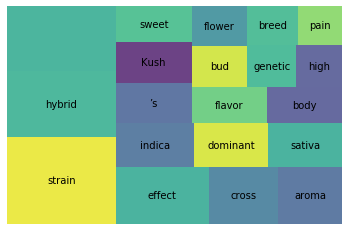

In [57]:
# for hybrid
wc = count(df_hybrid['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

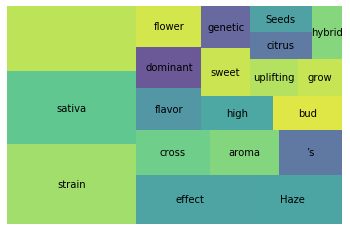

In [58]:
# for sativa
wc = count(df_sativa['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()

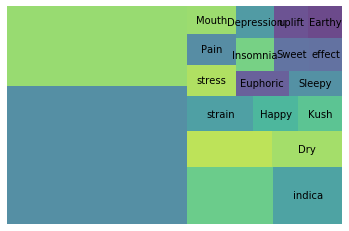

In [51]:
# for indica
wc = count(df_indica['lemmas'])
wc_top20 = wc[wc['rank'] <= 20]

squarify.plot(sizes=wc_top20['pct_total'], label=wc_top20['word'], alpha=.8 )
plt.axis('off')
plt.show()